In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge

In [2]:
import pickle as pkl

In [3]:
merged_data_train = pd.read_csv("simple_train_ip.csv")
merged_data_test = pd.read_csv("simple_test_ip.csv.")

In [5]:
merged_data_train.head(1)

,V4,V6,Target,V18,V19,asn_mapping,V5_hour,V5_minute,V13_hour,V13_minute,...,V5_year,V13_day_of_week,V13_day_of_month,V13_month,V13_year,V16_day_of_week,V16_day_of_month,V16_month,V16_year,country_mapping_encoded
0,485.69445,376474,0,24.492806,0.0,-1.0,22,51,0.0,0.0,...,2020,5.0,21.0,3.0,2020.0,2.0,15.0,1.0,2018.0,38


In [6]:
d = dict(merged_data_train.iloc[0])

In [7]:
d

{'V4': 485.69445,
 'V6': 376474.0,
 'Target': 0.0,
 'V18': 24.49280553477018,
 'V19': 0.0,
 'asn_mapping': -1.0,
 'V5_hour': 22.0,
 'V5_minute': 51.0,
 'V13_hour': 0.0,
 'V13_minute': 0.0,
 'V16_hour': 9.439085037839128,
 'V16_minute': 4.0,
 'V5_day_of_week': 4.0,
 'V5_day_of_month': 20.0,
 'V5_month': 3.0,
 'V5_year': 2020.0,
 'V13_day_of_week': 5.0,
 'V13_day_of_month': 21.0,
 'V13_month': 3.0,
 'V13_year': 2020.0,
 'V16_day_of_week': 2.0,
 'V16_day_of_month': 15.0,
 'V16_month': 1.0,
 'V16_year': 2018.0,
 'country_mapping_encoded': 38.0}

In [3]:
merged_data_train.columns

Index(['V4', 'V6', 'Target', 'V18', 'V19', 'asn_mapping', 'V5_hour',
       'V5_minute', 'V13_hour', 'V13_minute', 'V16_hour', 'V16_minute',
       'V5_day_of_week', 'V5_day_of_month', 'V5_month', 'V5_year',
       'V13_day_of_week', 'V13_day_of_month', 'V13_month', 'V13_year',
       'V16_day_of_week', 'V16_day_of_month', 'V16_month', 'V16_year',
       'country_mapping_encoded'],
      dtype='object')

In [5]:
merged_data_train.shape,merged_data_test.shape

((721081, 25), (658493, 24))

In [6]:
X = merged_data_train.drop(columns=['Target'])
y = merged_data_train['Target']

In [7]:
cat_columns = X.select_dtypes(include=['object']).columns
cat_features_idx = [X.columns.get_loc(col) for col in cat_columns]

In [8]:
cat_features_idx

[]

In [9]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                   )


In [10]:
X_test.shape

(144217, 24)

In [13]:
request_sample  = dict(X_test.iloc[0])

In [14]:
request_sample

{'V4': 480.125,
 'V6': 0.0,
 'V18': 0.0,
 'V19': 0.0,
 'asn_mapping': -1.0,
 'V5_hour': 21.0,
 'V5_minute': 11.0,
 'V13_hour': 0.0,
 'V13_minute': 0.0,
 'V16_hour': 3.0,
 'V16_minute': 47.0,
 'V5_day_of_week': 1.0,
 'V5_day_of_month': 16.0,
 'V5_month': 6.0,
 'V5_year': 2020.0,
 'V13_day_of_week': 6.0,
 'V13_day_of_month': 7.0,
 'V13_month': 7.0,
 'V13_year': 2020.0,
 'V16_day_of_week': 6.0,
 'V16_day_of_month': 15.0,
 'V16_month': 4.0,
 'V16_year': 2018.0,
 'country_mapping_encoded': 38.0}

In [28]:
test_sample = pd.DataFrame([request_sample], columns=list(request_sample.keys()))

In [26]:
def load_model(model_path):
    with open(model_path, 'rb') as model_file:
        model = pkl.load(model_file)
    return model

In [27]:
model = load_model('best_model.pkl')

In [42]:
model.predict_proba(test_sample)

array([[9.99996225e-01, 3.77529402e-06]])

In [49]:
confidence_scores = model.predict_proba(X_test.head())

In [50]:
confidence_scores

array([[9.99996225e-01, 3.77529402e-06],
       [9.99990347e-01, 9.65307747e-06],
       [9.99925568e-01, 7.44321727e-05],
       [9.99995020e-01, 4.97980447e-06],
       [9.99733226e-01, 2.66774488e-04]])

In [70]:
def get_result(test_sample):

    confidence_scores = model.predict_proba(test_sample)
    non_fraud_confidence_scores = [confidence_scores[i][0] for i in range(len(test_sample))]
    res_list = [0 if non_fraud_confidence >= 0.5 else 1 for non_fraud_confidence in non_fraud_confidence_scores]
    
    confidence_scores = [100 * (confidence_scores[i][res_list[i]]) for i in range(len(test_sample))]
    res = ["non_fraud" if res == 0 else 'fraud' for res in res_list]
    
    print(f"non fraud confidence_scores: {confidence_scores}")
    print(f"res_list: {res}")
    
    output = pd.DataFrame({"prediction": res, "confidence_scores": confidence_scores})
    return output

In [79]:
test_sample = X_test.head()

In [80]:
test_sample["transaction_id"] = [i for i in range(len(test_sample))]

C:\Users\rahul\AppData\Local\Temp\ipykernel_10960\1846613569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample["transaction_id"] = [i for i in range(len(test_sample))]


In [81]:
pwd

'D:\\jupyter\\fraud_transaction_project_cdac\\best_aaproach'

In [82]:
test_sample.head().to_csv("../vik_approach/test_sample_for_api.csv", index=False)

In [83]:
test_sample

,V4,V6,V18,V19,asn_mapping,V5_hour,V5_minute,V13_hour,V13_minute,V16_hour,...,V13_day_of_week,V13_day_of_month,V13_month,V13_year,V16_day_of_week,V16_day_of_month,V16_month,V16_year,country_mapping_encoded,transaction_id
288378,480.125,0,0.000000,0.0,-1.0,21,11,0.0,0.0,3.0,...,6.0,7.0,7.0,2020.0,6.0,15.0,4.0,2018.0,38,0
284877,208.750,0,0.000000,1036290.0,209910.0,2,12,0.0,0.0,0.0,...,6.0,7.0,7.0,2020.0,5.0,23.0,12.0,2017.0,32,1
656591,8.350,33227,24.492806,0.0,-1.0,20,40,0.0,0.0,10.0,...,2.0,22.0,1.0,2020.0,2.0,15.0,1.0,2018.0,38,2
81627,167.000,0,0.000000,1036290.0,209910.0,5,11,0.0,0.0,14.0,...,6.0,7.0,7.0,2020.0,2.0,28.0,3.0,2018.0,32,3
561437,918.500,2789,0.000000,0.0,-1.0,4,52,0.0,0.0,1.0,...,0.0,24.0,8.0,2020.0,1.0,29.0,5.0,2018.0,38,4


In [85]:
req = test_sample.to_dict()

In [88]:
data = pd.DataFrame(req, columns=list(req.keys()))

In [89]:
data

,V4,V6,V18,V19,asn_mapping,V5_hour,V5_minute,V13_hour,V13_minute,V16_hour,...,V13_day_of_week,V13_day_of_month,V13_month,V13_year,V16_day_of_week,V16_day_of_month,V16_month,V16_year,country_mapping_encoded,transaction_id
288378,480.125,0,0.000000,0.0,-1.0,21,11,0.0,0.0,3.0,...,6.0,7.0,7.0,2020.0,6.0,15.0,4.0,2018.0,38,0
284877,208.750,0,0.000000,1036290.0,209910.0,2,12,0.0,0.0,0.0,...,6.0,7.0,7.0,2020.0,5.0,23.0,12.0,2017.0,32,1
656591,8.350,33227,24.492806,0.0,-1.0,20,40,0.0,0.0,10.0,...,2.0,22.0,1.0,2020.0,2.0,15.0,1.0,2018.0,38,2
81627,167.000,0,0.000000,1036290.0,209910.0,5,11,0.0,0.0,14.0,...,6.0,7.0,7.0,2020.0,2.0,28.0,3.0,2018.0,32,3
561437,918.500,2789,0.000000,0.0,-1.0,4,52,0.0,0.0,1.0,...,0.0,24.0,8.0,2020.0,1.0,29.0,5.0,2018.0,38,4


In [71]:
get_result(X_test.head())

non fraud confidence_scores: [99.99962247059796, 99.9990346922534, 99.99255678273052, 99.99950201955326, 99.97332255118447]
res_list: ['non_fraud', 'non_fraud', 'non_fraud', 'non_fraud', 'non_fraud']


,prediction,confidence_scores
0,non_fraud,99.999622
1,non_fraud,99.999035
2,non_fraud,99.992557
3,non_fraud,99.999502
4,non_fraud,99.973323


In [37]:
1 if confidence_scores[0][1] >= 0.5 else 0

0

In [10]:

# Define model and its hyperparameters
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           l2_leaf_reg=3, 
                           loss_function='Logloss', 
                           random_seed=42,
                          cat_features=cat_features_idx)

# Train model on training data
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test), 
          verbose=100, 
          early_stopping_rounds=50)



0:	learn: 0.4014888	test: 0.4013880	best: 0.4013880 (0)	total: 224ms	remaining: 3m 44s
100:	learn: 0.0053234	test: 0.0057384	best: 0.0057384 (100)	total: 7.83s	remaining: 1m 9s
200:	learn: 0.0042935	test: 0.0051765	best: 0.0051765 (200)	total: 15.8s	remaining: 1m 2s
300:	learn: 0.0035996	test: 0.0047878	best: 0.0047863 (298)	total: 22.5s	remaining: 52.3s
400:	learn: 0.0031710	test: 0.0045634	best: 0.0045634 (400)	total: 28.9s	remaining: 43.1s
500:	learn: 0.0028102	test: 0.0044291	best: 0.0044240 (498)	total: 35.4s	remaining: 35.2s
600:	learn: 0.0025314	test: 0.0043516	best: 0.0043491 (597)	total: 41.8s	remaining: 27.8s
700:	learn: 0.0023052	test: 0.0042683	best: 0.0042650 (692)	total: 48.3s	remaining: 20.6s
800:	learn: 0.0021826	test: 0.0042543	best: 0.0042539 (790)	total: 54.6s	remaining: 13.6s
900:	learn: 0.0020332	test: 0.0042217	best: 0.0042188 (896)	total: 1m 1s	remaining: 6.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.004209484074
bestIteration = 934

S

In [11]:
# Evaluate model on testing data
score = model.score(X_test, y_test)
print(f"Accuracy on testing data: {score}")

Accuracy on testing data: 0.9989321647239923


In [12]:
y_pred = model.predict(X_test)

In [13]:
from sklearn.metrics import classification_report, precision_recall_curve, auc

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138842
           1       1.00      0.97      0.99      5375

    accuracy                           1.00    144217
   macro avg       1.00      0.99      0.99    144217
weighted avg       1.00      1.00      1.00    144217



In [15]:
precision, recall, thrs = precision_recall_curve(y_test, y_pred)

In [16]:
max(0, 100 * auc(precision, recall))

94.88531560127878

In [17]:
import catboost as cb

# Assuming you have a trained CatBoost model named 'model'

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = model.feature_names_

# Pair feature importances with feature names
feature_importances = list(zip(feature_names, importances))

# Sort feature importances in descending order
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Print feature importances
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


V5_month: 14.988792565700889
V6: 14.725153727841292
V13_year: 12.762463538126694
V4: 11.982157337702269
V13_month: 8.924969039959851
V5_day_of_month: 8.073628919841472
V5_day_of_week: 7.213415471038717
V13_day_of_month: 7.20436287740644
V5_hour: 6.460174984217833
V13_day_of_week: 4.645830427092526
V5_minute: 1.5776610288858004
V18: 0.5725576531549788
V16_minute: 0.41872752213625625
V16_hour: 0.3441883965198556
V16_day_of_week: 0.037826637491980244
V16_year: 0.034723165024023325
V16_day_of_month: 0.016061050026863262
asn_mapping: 0.008828739747575021
V19: 0.00454727801766274
country_mapping_encoded: 0.003929640067023044
V13_hour: 0.0
V13_minute: 0.0
V5_year: 0.0
V16_month: 0.0


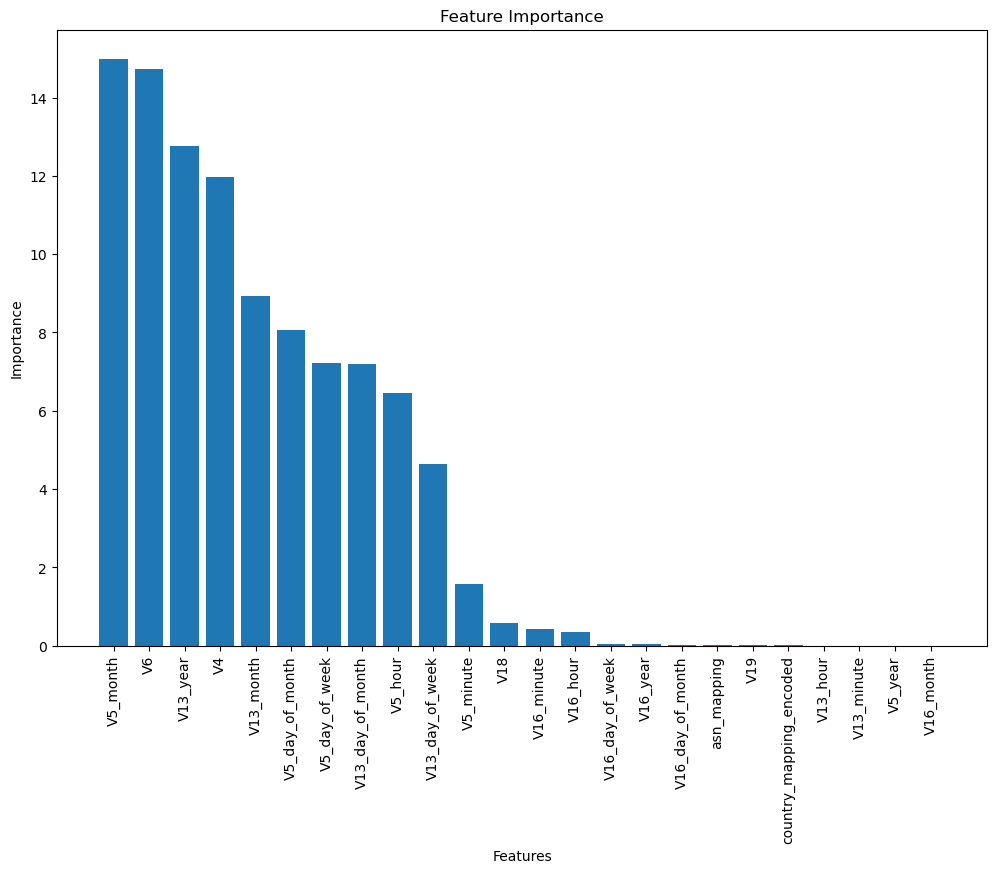

In [18]:
import matplotlib.pyplot as plt

# Assuming you have a list of feature names and their importance values
feature_names = [
    "V5_month", "V6", "V13_year", "V4", "V13_month", "V5_day_of_month",
    "V5_day_of_week", "V13_day_of_month", "V5_hour", "V13_day_of_week",
    "V5_minute", "V18", "V16_minute", "V16_hour", "V16_day_of_week",
    "V16_year", "V16_day_of_month", "asn_mapping", "V19",
    "country_mapping_encoded", "V13_hour", "V13_minute", "V5_year",
    "V16_month"
]
importance_values = [
    14.988792565700889, 14.725153727841292, 12.762463538126694,
    11.982157337702269, 8.924969039959851, 8.073628919841472,
    7.213415471038717, 7.20436287740644, 6.460174984217833,
    4.645830427092526, 1.5776610288858004, 0.5725576531549788,
    0.41872752213625625, 0.3441883965198556, 0.037826637491980244,
    0.034723165024023325, 0.016061050026863262, 0.008828739747575021,
    0.00454727801766274, 0.003929640067023044, 0.0, 0.0, 0.0, 0.0
]

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(feature_names, importance_values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')

plt.show()




In [19]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, classification_report
# from skopt import BayesSearchCV

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the CatBoost model for classification
# model = CatBoostClassifier()

# # Define the hyperparameter search space for Bayesian optimization
# param_space = {
#     'max_depth': (3, 7),
#     'learning_rate': (0.01, 0.3, 'log-uniform'),
#     'n_estimators': (100, 300),
# }

# # Perform Bayesian optimization to find the best hyperparameters
# bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, scoring='f1_macro', cv=5)
# bayes_search.fit(X_train, y_train)

# # Get the best model from the Bayesian optimization
# best_model = bayes_search.best_estimator_

# # Make predictions on the test set using the best model
# y_pred = best_model.predict(X_test)

# # Compute the F1 score
# f1 = f1_score(y_test, y_pred)

# # Print the classification report
# report = classification_report(y_test, y_pred)
# print("F1 Score:", f1)
# print("Classification Report:\n", report)


In [20]:
precision, recall, thrs = precision_recall_curve(y_test, y_pred)

In [21]:
max(0, 100 * auc(precision, recall))

94.88531560127878

In [22]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, classification_report

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the XGBoost model for classification
# model_ = xgb.XGBClassifier()

# # Train the model
# model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test)

# # Compute the F1 score
# f1 = f1_score(y_test, y_pred)

# # Print the classification report
# report = classification_report(y_test, y_pred)
# print("F1 Score:", f1)
# print("Classification Report:\n", report)


In [23]:
import xgboost as xgb

# Assuming you have a trained XGBoost model named 'model'
# and the preprocessed feature data is stored in 'X'

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = X.columns

# Pair feature importances with feature names
feature_importances = list(zip(feature_names, importances))

# Sort feature importances in descending order
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Print feature importances
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


V5_month: 14.988792565700889
V6: 14.725153727841292
V13_year: 12.762463538126694
V4: 11.982157337702269
V13_month: 8.924969039959851
V5_day_of_month: 8.073628919841472
V5_day_of_week: 7.213415471038717
V13_day_of_month: 7.20436287740644
V5_hour: 6.460174984217833
V13_day_of_week: 4.645830427092526
V5_minute: 1.5776610288858004
V18: 0.5725576531549788
V16_minute: 0.41872752213625625
V16_hour: 0.3441883965198556
V16_day_of_week: 0.037826637491980244
V16_year: 0.034723165024023325
V16_day_of_month: 0.016061050026863262
asn_mapping: 0.008828739747575021
V19: 0.00454727801766274
country_mapping_encoded: 0.003929640067023044
V13_hour: 0.0
V13_minute: 0.0
V5_year: 0.0
V16_month: 0.0


In [24]:
precision, recall, thrs = precision_recall_curve(y_test, y_pred)

In [25]:
max(0, 100 * auc(precision, recall))

94.88531560127878

In [26]:
# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the XGBoost model for classification
# model = xgb.XGBClassifier()

# # Define the hyperparameter search space for Bayesian optimization
# param_space = {
#     'max_depth': (3, 7),
#     'learning_rate': (0.001, 0.1, 'log-uniform'),
#     'n_estimators': (100, 300),
# }

# # Perform Bayesian optimization to find the best hyperparameters
# bayes_search = BayesSearchCV(estimator=model, search_spaces=param_space, scoring='f1_macro', cv=5)
# bayes_search.fit(X_train, y_train)

# # Get the best model from the Bayesian optimization
# best_model = bayes_search.best_estimator_

# # Make predictions on the test set using the best model
# y_pred = best_model.predict(X_test)

# # Compute the F1 score
# f1 = f1_score(y_test, y_pred)

# # Print the classification report
# report = classification_report(y_test, y_pred)
# print("F1 Score:", f1)
# print("Classification Report:\n", report)


In [27]:
precision, recall, thrs = precision_recall_curve(y_test, y_pred)

In [28]:
max(0, 100 * auc(precision, recall))

94.88531560127878

In [29]:
import pickle


In [30]:
# Assuming you have trained a model and stored it in the `model` variable
with open('best_model.pkl', 'wb') as file:
    pickle.dump(model, file)
